In [58]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
def char_level_to_spans(df, thold):
    spans_all = []
    for sample_id, group in df.groupby("id"):
        spans = []
        current_span = None
        for _, row in group.iterrows():
            if row["proba"] >= thold:
                if current_span is None:
                    current_span = [row["char_index"], row["char_index"] + 1]
                else:
                    current_span[1] = row["char_index"] + 1
            else:
                if current_span is not None:
                    spans.append(tuple(current_span))
                    current_span = None
        if current_span is not None:
            spans.append(tuple(current_span))
        spans_all.append({"id": sample_id, "trigger_words": spans})
    return pd.DataFrame(spans_all)

In [61]:
def find_optimal_threshold(probabilities, desired_positive_ratio):
    """Finds the threshold that achieves the desired positive class balance."""
    best_th = 0.5  # Default starting point
    best_diff = float("inf")
    optimal_th = best_th
    
    for thold in np.linspace(0.01, 0.99, num=100):
        positive_ratio = (probabilities >= thold).mean()
        diff = abs(positive_ratio - desired_positive_ratio)
        if diff < best_diff:
            best_diff = diff
            optimal_th = thold
    
    return optimal_th

In [11]:
data_path = "../../data/"
cv_path = "../../cv_split.csv"

df = pd.read_parquet(data_path + "train.parquet")
cv = pd.read_csv(cv_path)
df = df.merge(cv, on='id', how='left')

df_test = pd.read_csv(data_path + "test.csv")
df_valid = df[df['fold']==4]

In [57]:
def df_text_to_char(df, id_column, text_column):
    output = []
    for _, row in df.iterrows():
        output += [{'id': row[id_column], 'char_index': ii} for ii in range(len(row[text_column]))]

    return pd.DataFrame(output)

In [62]:
CLASS_BALANCE = 0.228

# Valid

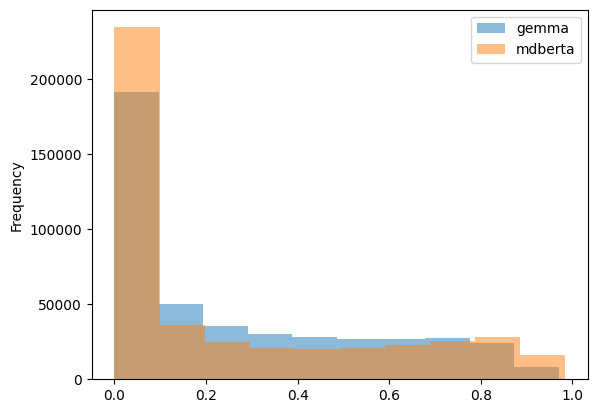

In [60]:
df_valid_char = df_text_to_char(df_valid, 'id', 'content')
gemma_char_cv_preds = pd.read_csv("../tmp_data/char_cv_preds_unsloth-gemma-2-2b-it-bnb-4bit.csv", index_col=0)
mdeberta_char_cv_preds = pd.read_csv("../tmp_data/char_cv_preds_mdeberta-v3-base.csv", index_col=0)

df_valid_char_preds = df_valid_char.merge(
    gemma_char_cv_preds,
    on=['id', 'char_index'], how='left'
).merge(
    mdeberta_char_cv_preds,
    on=['id', 'char_index'], how='left',
    suffixes=['_gemma', '_mdberta']
).fillna(0)


df_valid_char_preds['proba_gemma'].plot(kind='hist', alpha=0.5, label='gemma')
df_valid_char_preds['proba_mdberta'].plot(kind='hist', alpha=0.5, label='mdberta')

df_valid_char_preds['proba'] = (df_valid_char_preds['proba_gemma'] + df_valid_char_preds['proba_mdberta'])/2

plt.legend()

In [63]:
find_optimal_threshold(df_valid_char_preds['proba'], 0.228)

0.5049494949494949

# Test

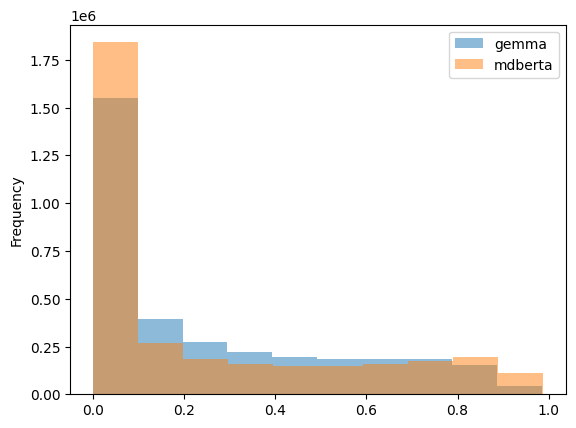

In [64]:
df_test_char = df_text_to_char(df_test, 'id', 'content')
gemma_char_test_preds = pd.read_csv("../tmp_data/char_test_preds_unsloth-gemma-2-2b-it-bnb-4bit.csv", index_col=0)
mdeberta_char_test_preds = pd.read_csv("../tmp_data/char_test_preds_mdeberta-v3-base.csv", index_col=0)

df_test_char_preds = df_test_char.merge(
    gemma_char_test_preds,
    on=['id', 'char_index'], how='left'
).merge(
    mdeberta_char_test_preds,
    on=['id', 'char_index'], how='left',
    suffixes=['_gemma', '_mdberta']
).fillna(0)


df_test_char_preds['proba_gemma'].plot(kind='hist', alpha=0.5, label='gemma')
df_test_char_preds['proba_mdberta'].plot(kind='hist', alpha=0.5, label='mdberta')

df_test_char_preds['proba'] = (df_test_char_preds['proba_gemma'] + df_test_char_preds['proba_mdberta'])/2

plt.legend()

In [65]:
find_optimal_threshold(df_test_char_preds['proba'], 0.228)

0.47525252525252526

In [105]:
# final_th = (0.504 + 0.4752) / 2 - 0.15

# (gemma_th + mdberta_th) / 2
final_th = (0.265325 + 0.3)/2

final_th

0.2826625

# Metric

In [106]:
import pandas as pd
import pandas.api.types
from sklearn.metrics import f1_score
import ast


class ParticipantVisibleError(Exception):
    """Custom exception for participant-visible errors."""
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Compute span-level F1 score based on overlap.

    Parameters:
    - solution (pd.DataFrame): Ground truth DataFrame with row ID and token labels.
    - submission (pd.DataFrame): Submission DataFrame with row ID and token labels.
    - row_id_column_name (str): Column name for the row identifier.

    Returns:
    - float: The token-level weighted F1 score.

    Example:
    >>> solution = pd.DataFrame({
    ...     "id": [1, 2, 3],
    ...     "trigger_words": [[(612, 622), (725, 831)], [(300, 312)], []]
    ... })
    >>> submission = pd.DataFrame({
    ...     "id": [1, 2, 3],
    ...     "trigger_words": [[(612, 622), (700, 720)], [(300, 312)], [(100, 200)]]
    ... })
    >>> score(solution, submission, "id")
    0.16296296296296295
    """
    if not all(col in solution.columns for col in ["id", "trigger_words"]):
        raise ValueError("Solution DataFrame must contain 'id' and 'trigger_words' columns.")
    if not all(col in submission.columns for col in ["id", "trigger_words"]):
        raise ValueError("Submission DataFrame must contain 'id' and 'trigger_words' columns.")
    
    def safe_parse_spans(trigger_words):
        if isinstance(trigger_words, str):
            try:
                return ast.literal_eval(trigger_words)
            except (ValueError, SyntaxError):
                return []
        if isinstance(trigger_words, (list, tuple, np.ndarray)):
            return trigger_words
        return []

    def extract_tokens_from_spans(spans):
        tokens = set()
        for start, end in spans:
            tokens.update(range(start, end))
        return tokens
    
    solution = solution.copy()
    submission = submission.copy()

    solution["trigger_words"] = solution["trigger_words"].apply(safe_parse_spans)
    submission["trigger_words"] = submission["trigger_words"].apply(safe_parse_spans)

    merged = pd.merge(
        solution,
        submission,
        on="id",
        suffixes=("_solution", "_submission")
    )

    total_true_tokens = 0
    total_pred_tokens = 0
    overlapping_tokens = 0

    for _, row in merged.iterrows():
        true_spans = row["trigger_words_solution"]
        pred_spans = row["trigger_words_submission"]

        true_tokens = extract_tokens_from_spans(true_spans)
        pred_tokens = extract_tokens_from_spans(pred_spans)

        total_true_tokens += len(true_tokens)
        total_pred_tokens += len(pred_tokens)
        overlapping_tokens += len(true_tokens & pred_tokens)

    precision = overlapping_tokens / total_pred_tokens if total_pred_tokens > 0 else 0
    recall = overlapping_tokens / total_true_tokens if total_true_tokens > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1

In [ ]:
from copy import deepcopy

df_gt = df[df.fold==4][['id', 'trigger_words']].reset_index(drop=True)
df_pred = deepcopy(df_gt)


valid_preds = char_level_to_spans(df_valid_char_preds, final_th)

score(df_gt, valid_preds, row_id_column_name='id')

0.6324769692146771

In [108]:
char_level_to_spans(df_test_char_preds, final_th).to_csv("../tmp_data/char_ensemble_cv0.632.csv", index=False)